<a href="https://colab.research.google.com/github/PODEE/PODEE/blob/main/LE_Regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

##Load & Explore Data

In [30]:
df = pd.read_excel("AVS.xlsx")
df.head(5)

,Gender,DOB,Report Date,Smoking Class,Primary Diagnosis,MortalityFactor,Age,LE-Months
0,Female,1927-12-12,2018-11-12,Non-Smoker,Atrial Fibrillation,155,90.916667,64
1,Male,1926-09-25,2018-11-13,Non-Smoker,Build,150,92.133333,54
2,Male,1944-04-11,2018-11-15,Non-Smoker,Alzheimer's Disease,665,74.594444,76
3,Male,1934-10-26,2018-11-16,Non-Smoker,Miscellaneous,150,84.055556,94
4,Female,1930-09-16,2018-11-19,Non-Smoker,Alzheimer's Disease,450,88.175000,36


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Gender             561 non-null    object        
 1   DOB                561 non-null    datetime64[ns]
 2   Report Date        561 non-null    datetime64[ns]
 3   Smoking Class      561 non-null    object        
 4   Primary Diagnosis  561 non-null    object        
 5   MortalityFactor    561 non-null    int64         
 6   Age                561 non-null    float64       
 7   LE-Months          561 non-null    int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 35.2+ KB


In [32]:
df.columns

Index(['Gender', 'DOB', 'Report Date', 'Smoking Class', 'Primary Diagnosis',
       'MortalityFactor', 'Age', 'LE-Months'],
      dtype='object')

In [33]:
df['Smoking Class'].value_counts()
df['Gender'].value_counts()
#df['Primary Diagnosis'].value_counts()

Male      392
Female    169
Name: Gender, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6de40fd10>,
      dtype=object)

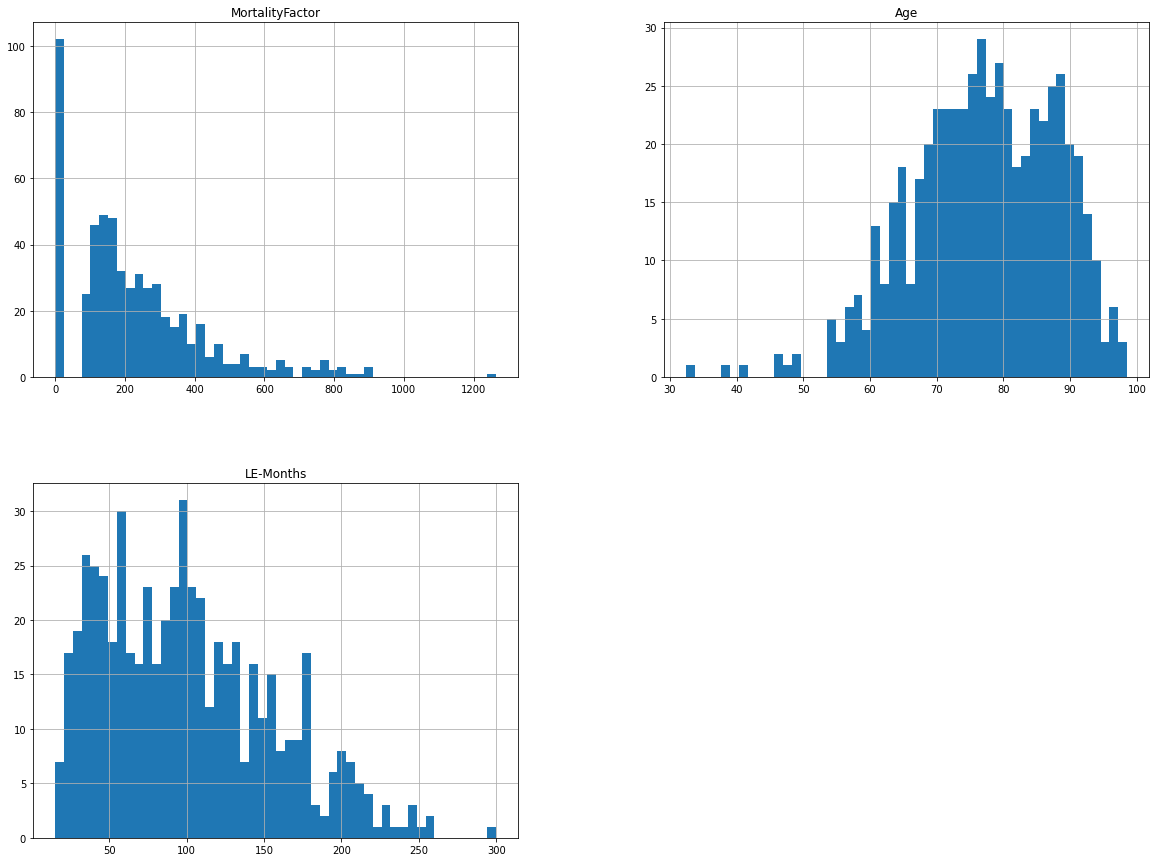

In [34]:
df.hist(bins=50, figsize=(20,15)) #Histogram exploring Numeric Data

In [35]:
from sklearn.model_selection import  train_test_split #split 90% for training, 10% for testing
train, test = train_test_split(df, test_size=0.1, random_state=42)

In [36]:
len(train), len(test)

(504, 57)

In [37]:
corr_matrix = train.corr()
corr_matrix
corr_matrix['LE-Months'].sort_values(ascending=False)

LE-Months          1.000000
MortalityFactor   -0.074736
Age               -0.391264
Name: LE-Months, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6de3c4450>,
      dtype=object)

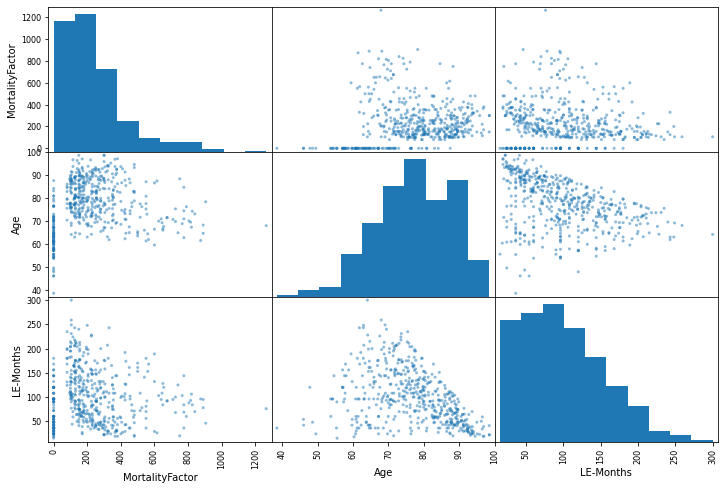

In [38]:
#Visualize correlation matrix
from pandas.plotting import scatter_matrix
scatter_matrix(train[['MortalityFactor', 'Age', 'LE-Months']], figsize=(12, 8))

In [39]:
X_train = train.drop('LE-Months', axis=1)
y_train = train['LE-Months'].copy()

In [40]:
#Separate numeric variables from categorical variables
X_train_num = X_train[['MortalityFactor', 'Age']]
X_train_cat = X_train.drop(['MortalityFactor', 'Age', 'Report Date', 'DOB'], axis=1)

In [41]:
#Start DataCleansing & Transformations
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

In [42]:
#Create a pipeline to transform numeric variables
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), #replace missing values with median
        ('std_scaler', StandardScaler()),
    ])

X_train_num_tr = num_pipeline.fit_transform(X_train_num)

In [43]:
#Use ColumnTransformer to transform all variables in a single step
from sklearn.compose import ColumnTransformer

num_attribs = list(X_train_num)
cat_attribs = list(X_train_cat)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

X_train_prepared = full_pipeline.fit_transform(X_train)

In [44]:
X_train_prepared.shape

(504, 54)

##1 - Multiple Regression Model

In [45]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [46]:
X_test = test.drop('LE-Months', axis=1)
y_test = test['LE-Months'].copy()

In [47]:
#Transform test data for predictions
X_test_prepared = full_pipeline.transform(X_test)
test_predictions_lin_reg = lin_reg.predict(X_test_prepared)

In [20]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(y_test, test_predictions_lin_reg)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

44.077651450507446

##2 - Decision Tree Regressor


In [21]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_prepared, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [22]:
test_predictions_tree = tree_reg.predict(X_test_prepared)

In [23]:
tree_mse = mean_squared_error(y_test, test_predictions_tree)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

26.502896233655857

##3 - Random Forest Regressor

In [24]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_prepared, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [25]:
test_predictions_forest = forest_reg.predict(X_test_prepared)

In [26]:
forest_mse = mean_squared_error(y_test, test_predictions_forest)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

26.608469532785854

## Better Evaluation Using Cross-Validation

In [49]:
from sklearn.model_selection import cross_val_score

#Lin_Reg
lin_scores = cross_val_score(lin_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

#DecisionTree
tree_scores = cross_val_score(tree_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

#DecisionTree
forest_scores = cross_val_score(forest_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [50]:
lin_rmse_scores.mean(), tree_rmse_scores.mean(), forest_rmse_scores.mean()

(42.83931010375802, 23.647657944650202, 18.75859052585728)

##Fine-Tune the Best Model

In [48]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30, 90], 'max_features': [2, 4, 6, 8, 54]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [51]:
grid_search.best_params_

{'max_features': 54, 'n_estimators': 10}

In [52]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=54, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [53]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([4.21761568e-01, 4.95013938e-01, 7.21903479e-03, 8.63205559e-03,
       6.49144493e-03, 6.51304147e-03, 1.00465610e-03, 7.77736588e-04,
       7.22224287e-04, 5.08148596e-05, 8.80524472e-04, 6.20395317e-05,
       1.08574930e-03, 2.01899960e-03, 1.27131038e-03, 4.53863803e-04,
       6.17432080e-05, 1.05112440e-02, 2.94709677e-03, 1.43259423e-03,
       1.27308994e-03, 6.53656427e-04, 1.92598700e-03, 1.79202655e-03,
       1.75536067e-03, 8.06035883e-04, 5.00229123e-05, 1.22796467e-03,
       7.32453798e-05, 1.31167851e-04, 7.27499608e-04, 5.80798264e-03,
       1.63111546e-05, 6.12198107e-05, 3.19846058e-05, 5.76341548e-03,
       1.54306501e-04, 1.73997273e-04, 8.65325096e-05, 1.70898830e-03,
       1.14073886e-04, 3.77157733e-05, 4.65953609e-04, 1.05898414e-03,
       7.60518286e-04, 3.30429394e-03, 2.05494900e-05, 1.37805507e-04,
       3.44094265e-04, 1.35049471e-04, 2.59536540e-04, 5.91972545e-05,
       7.07134112e-05, 9.90389383e-05])

In [54]:
cat_encoder = full_pipeline.named_transformers_["cat"]
#cat_one_hot_attribs = list(cat_encoder.categories_[0])
cat_one_hot_attribs = list(cat_encoder.categories_)
cat_one_hot_attribs

[array(['Female', 'Male'], dtype=object),
 array(['Non-Smoker', 'Smoker'], dtype=object),
 array(['ALS', 'Alcohol/Substance Abuse', "Alzheimer's Disease",
        'Aneurysm', 'Atrial Fibrillation', 'Build', 'CA Brain',
        'CA Breast', 'CA Colorectal', 'CA Digestive', 'CA Endocrine',
        'CA Head/Neck', 'CA Kidney', 'CA Lung', 'CA Other', 'CA Pancreas',
        'CA Prostate', 'CAD', 'COPD/Emphysema', 'CVA',
        'Cardiac Arrhythmia', 'Cardiovascular Disease',
        'Cardiovascular disease', 'Dementia', 'Diabetes', 'Elder',
        'Frailty', 'Kidney Failure', 'Kidney Transplant', 'Leukemia',
        'Liver Disease', 'Liver Transplant', 'MS', 'Melanoma',
        'Misc-hematology', 'Misc-lab abnormalities', 'Misc-neurology',
        'Miscellaneous', 'Multiple Myeloma', "Non-Hodgkin's Lymphoma",
        'Other', 'PVD', "Parkinson's Disease", 'Polycythemia',
        'Pulmonary Disease', 'Renal Insufficiency', 'Rheumatoid Arthritis',
        'TIA'], dtype=object)]

In [55]:
attributes = num_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.49501393814891875, 'Age'),
 (0.4217615682426381, 'MortalityFactor'),
 (0.008632055592110392, array(['Non-Smoker', 'Smoker'], dtype=object)),
 (0.007219034786263371, array(['Female', 'Male'], dtype=object)),
 (0.006491444931665909,
  array(['ALS', 'Alcohol/Substance Abuse', "Alzheimer's Disease",
         'Aneurysm', 'Atrial Fibrillation', 'Build', 'CA Brain',
         'CA Breast', 'CA Colorectal', 'CA Digestive', 'CA Endocrine',
         'CA Head/Neck', 'CA Kidney', 'CA Lung', 'CA Other', 'CA Pancreas',
         'CA Prostate', 'CAD', 'COPD/Emphysema', 'CVA',
         'Cardiac Arrhythmia', 'Cardiovascular Disease',
         'Cardiovascular disease', 'Dementia', 'Diabetes', 'Elder',
         'Frailty', 'Kidney Failure', 'Kidney Transplant', 'Leukemia',
         'Liver Disease', 'Liver Transplant', 'MS', 'Melanoma',
         'Misc-hematology', 'Misc-lab abnormalities', 'Misc-neurology',
         'Miscellaneous', 'Multiple Myeloma', "Non-Hodgkin's Lymphoma",
         'Other', 'PVD', "P

##Evaluate System on the Test Set

In [56]:
final_model = grid_search.best_estimator_

In [59]:
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) 
final_rmse

30.056093757004163

In [85]:
#Compare Predictions to Actual LEs in Test Set
dataset = pd.DataFrame()
dataset['Actual'] = y_test
dataset['Final_Predictions'] = final_predictions
dataset['%Error'] = ((dataset['Actual'] - dataset['Final_Predictions'])/dataset['Actual'])*100
dataset.to_csv("predicteds.csv", index=False)